In [1]:
#!conda activate tsr

In [2]:
# %pip install numpy pandas scikit-learn seaboarn matplotlib

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import sem
from sklearn.svm import SVC
from sklearn.datasets  import make_blobs
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample

In [5]:
n_samples = 3000  
n_features = 4    
n_clusters = 3    
random_state = 42 

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=random_state)

df1 = pd.DataFrame(X, columns=[f'feature_{i+1}' for i in range(n_features)])
df1['class'] = y

df1

feature_1  feature_2  feature_3  feature_4  class
0      1.717955   3.848523  -8.969754  11.383873      2
1      2.621390   4.337125 -10.556794   8.016428      2
2     -5.240667  -5.972087  -9.545767   9.533379      1
3     -2.283934   9.707009   3.370548   3.675684      0
4     -3.652217   9.834444   4.575190   2.046044      0
...         ...        ...        ...        ...    ...
2995  -1.935453   7.737982   3.351571   2.265885      0
2996  -1.032657  10.394377   4.014316   2.368973      0
2997  -1.242286   8.306617   5.083698   2.747804      0
2998  -8.844163  -8.361255  -8.840697   6.779916      1
2999  -6.718977  -6.217847  -9.877439   9.011071      1

[3000 rows x 5 columns]

In [6]:
df1_param_dict = {
    'shape': tuple(df1.shape),
    'feature_cnt': df1.drop('class', axis='columns').shape[1],
    'target_class_cnt': len(df1['class'].unique().tolist()), 
    'nan_prcnt': df1.isna().sum().sum()/(df1.size)
}

pd.DataFrame([df1_param_dict])

shape  feature_cnt  target_class_cnt  nan_prcnt
0  (3000, 5)            4                 3        0.0

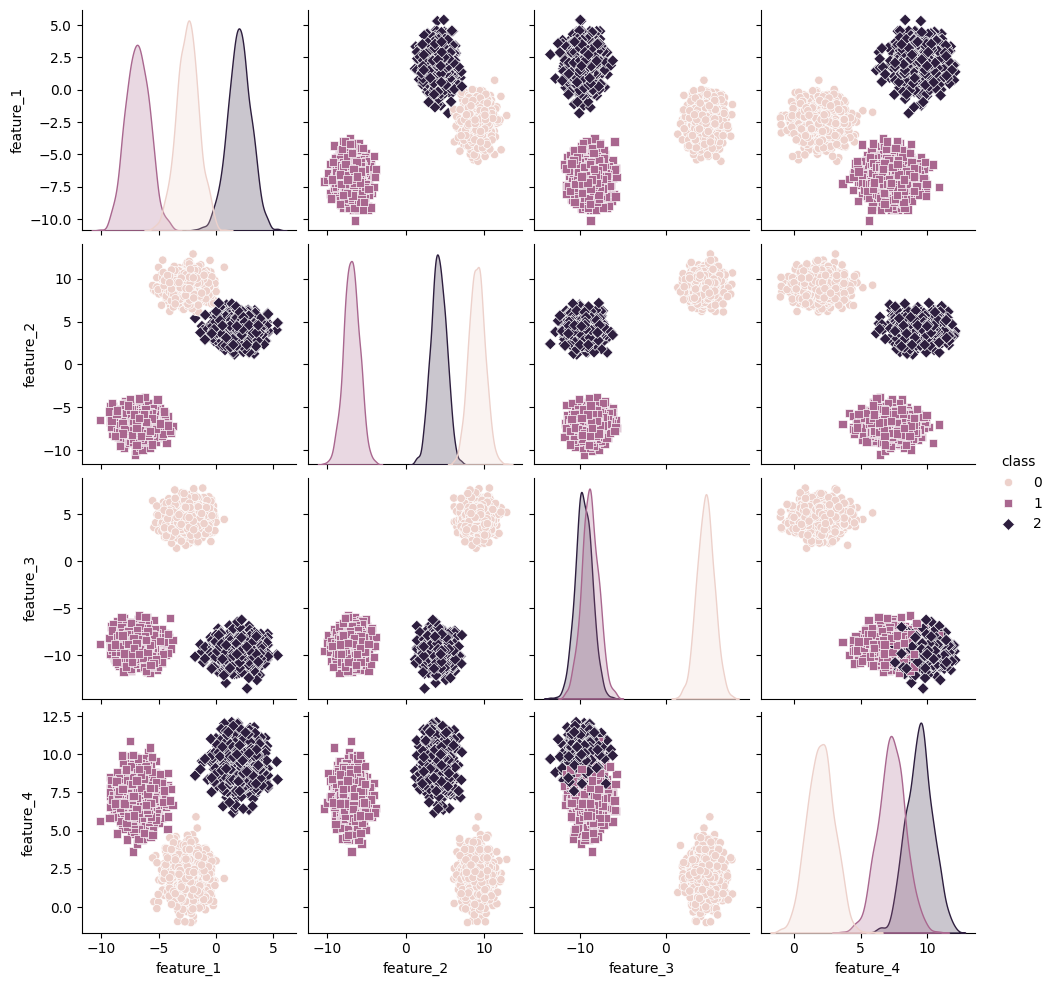

In [7]:
x = df1.drop('class', axis=1)
y = df1['class']

sns.pairplot(df1,
             vars=list(x.columns),
             hue=y.name,
             diag_kind='kde',
             markers=['o', 's', 'D']
)

plt.show()

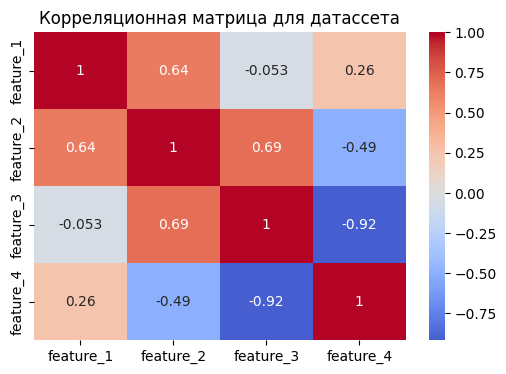

In [8]:
plt.figure(figsize=(6, 4)) 
sns.heatmap(x.corr(method='pearson'), annot=True, cmap='coolwarm', center=0)
plt.title(f'Корреляционная матрица для датассета')
plt.show()

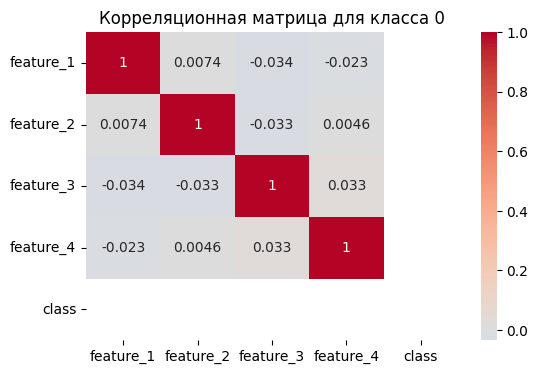

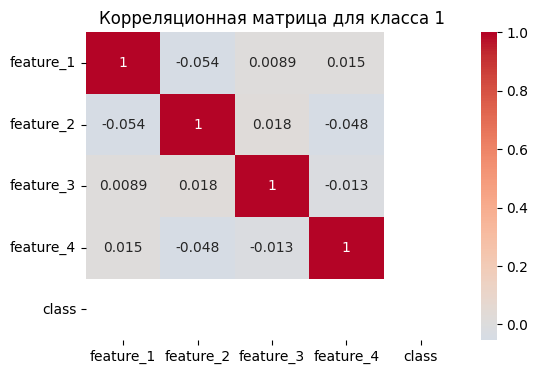

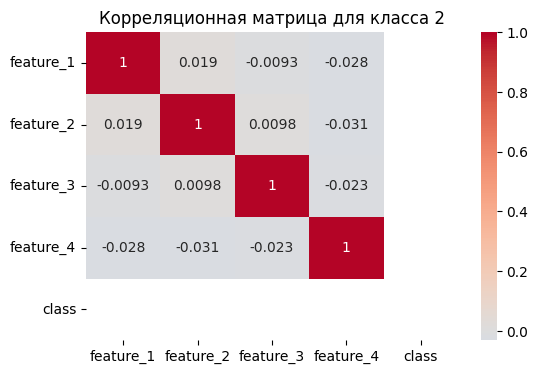

In [9]:
grouped_df1 = df1.groupby(y.name)

correlation_by_class = {}
for class_name, group in grouped_df1:
    numeric_data = group.select_dtypes(include=['float64', 'int64'])
    correlation_by_class[class_name] = numeric_data.corr(method='pearson')


for class_name, corr_matrix in correlation_by_class.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Корреляционная матрица для класса {class_name}')
    plt.show()

In [10]:
def generate_repeated_class_datasets(df, class_to_repeat, repeat_factors):
    datasets = {}
    
    class_data = df[df['class'] == class_to_repeat]
    other_data = df[df['class'] != class_to_repeat]
    
    for repeat_factor in repeat_factors:
        repeated_class_data = pd.concat([class_data] * repeat_factor, ignore_index=True)
        new_df = pd.concat([other_data, repeated_class_data], ignore_index=True)
        datasets[f'df{repeat_factor}'] = new_df
    
    return datasets

repeat_factors = [1, 2, 5, 10, 20, 50, 100, 1000, 10000]
repeated_datasets = generate_repeated_class_datasets(df1, class_to_repeat=0, repeat_factors=repeat_factors)

{key: df.shape for key, df in repeated_datasets.items()}


{'df1': (3000, 5),
 'df2': (4000, 5),
 'df5': (7000, 5),
 'df10': (12000, 5),
 'df20': (22000, 5),
 'df50': (52000, 5),
 'df100': (102000, 5),
 'df1000': (1002000, 5),
 'df10000': (10002000, 5)}

In [11]:
selected_classes = [0, 1]
unselected_features = ['feature_2', 'feature_3']

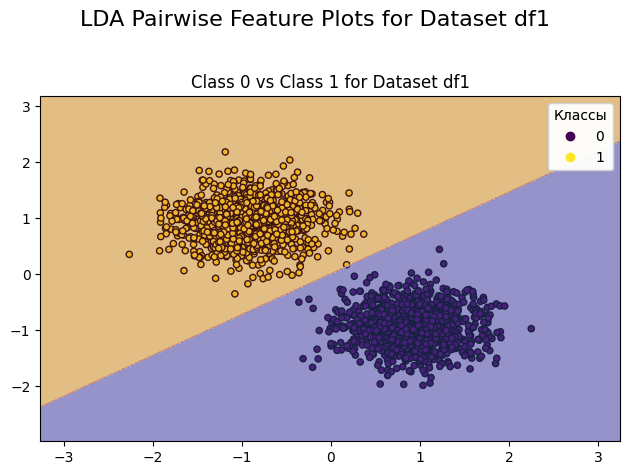

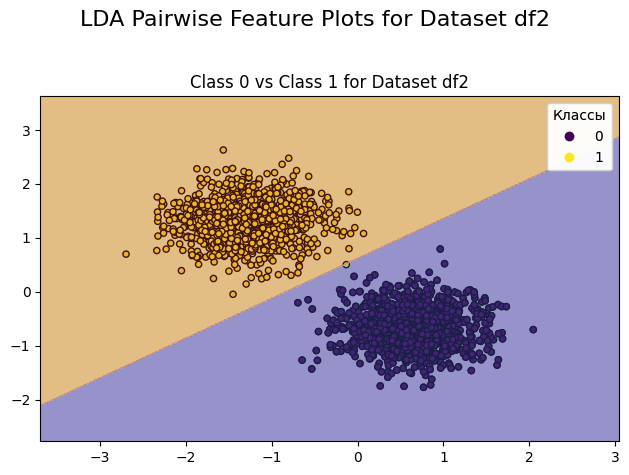

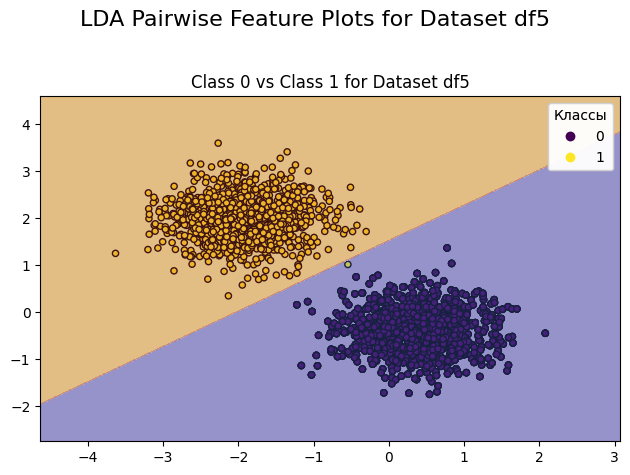

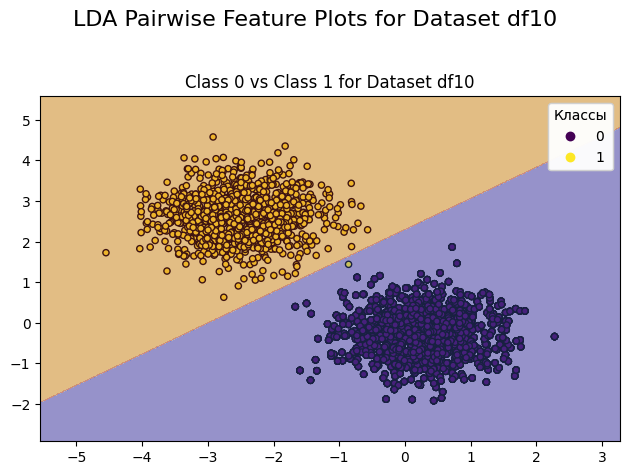

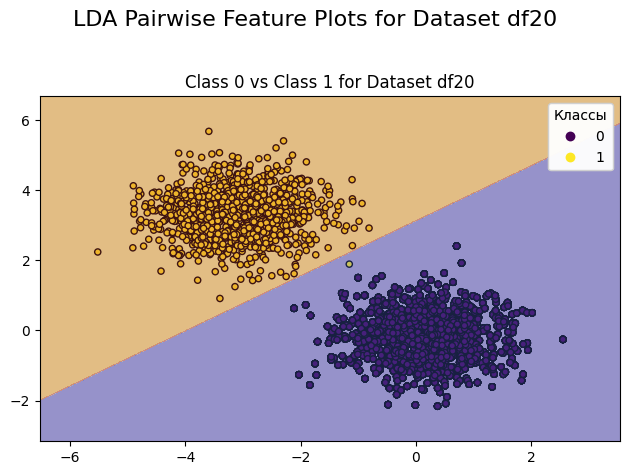

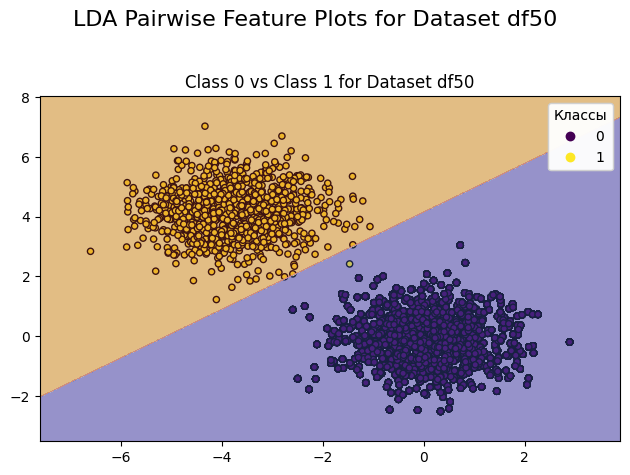

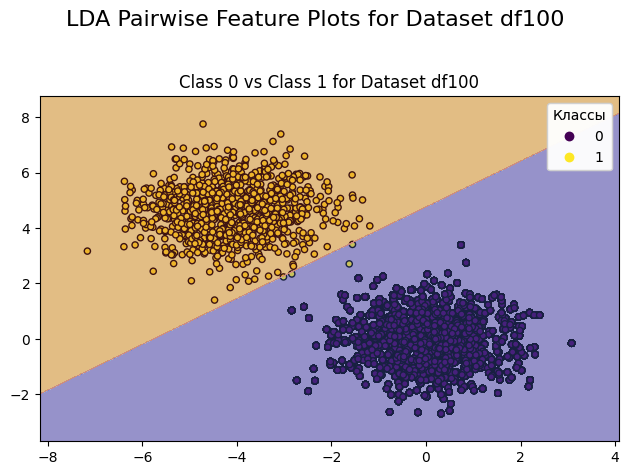

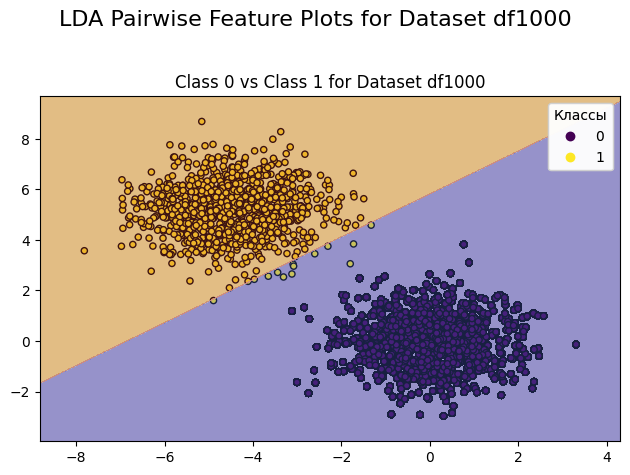

c:\Users\user\Desktop\pitux\тср\lab_1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


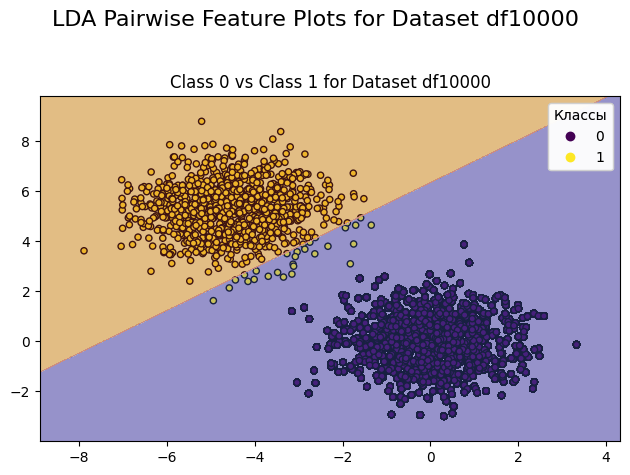

In [12]:
for dataset_name, dataset in repeated_datasets.items():
    dataset = dataset[dataset['class'].isin(selected_classes)]

    X = dataset.drop(['class'] + unselected_features, axis='columns')
    y = dataset['class']

    features_names = X.columns

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lda = LDA()
    lda.fit(X_scaled, y)

    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=20, edgecolor='k')
    legend1 = plt.legend(*scatter.legend_elements(), title="Классы")
    plt.gca().add_artist(legend1)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.title(f'Class {selected_classes[0]} vs Class {selected_classes[1]} for Dataset {dataset_name}')
    plt.suptitle(f'LDA Pairwise Feature Plots for Dataset {dataset_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

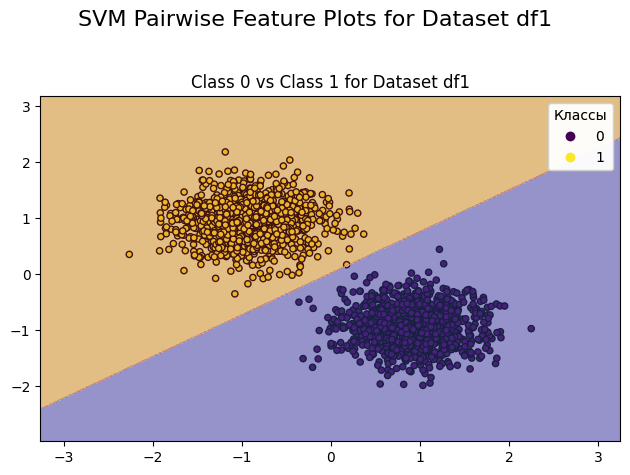

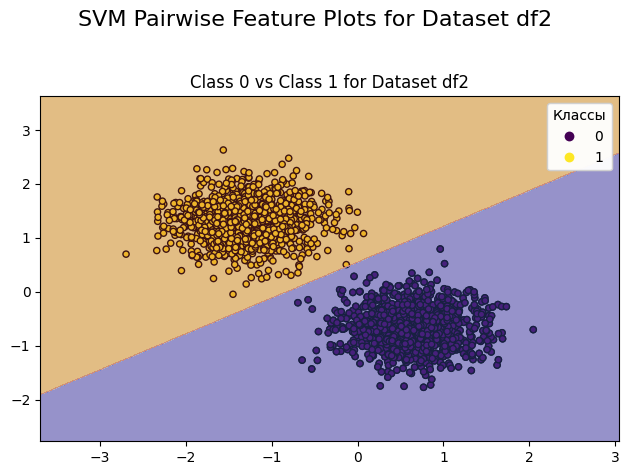

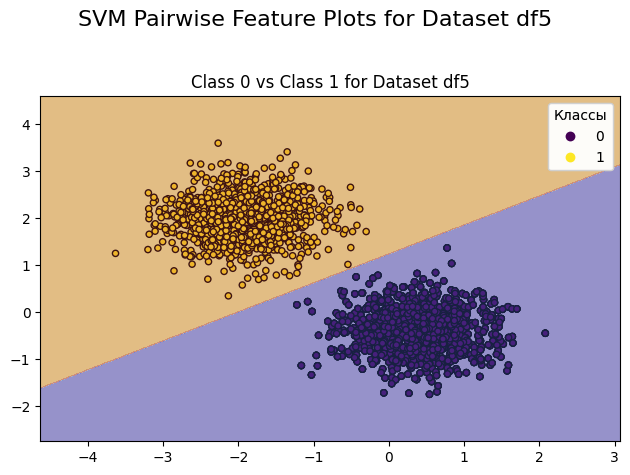

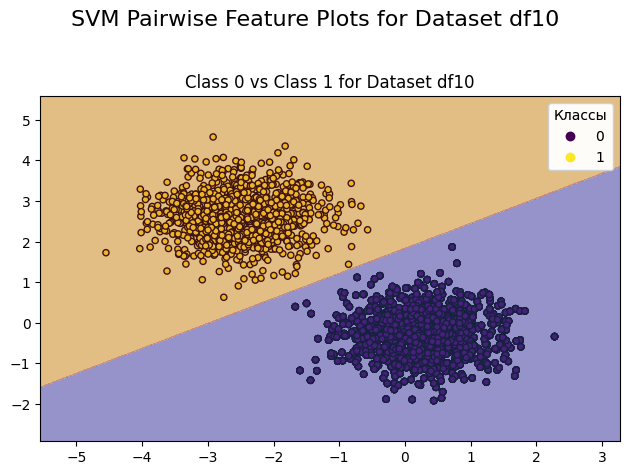

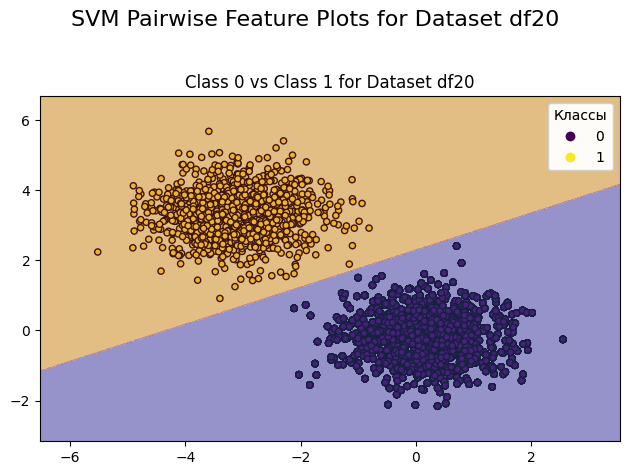

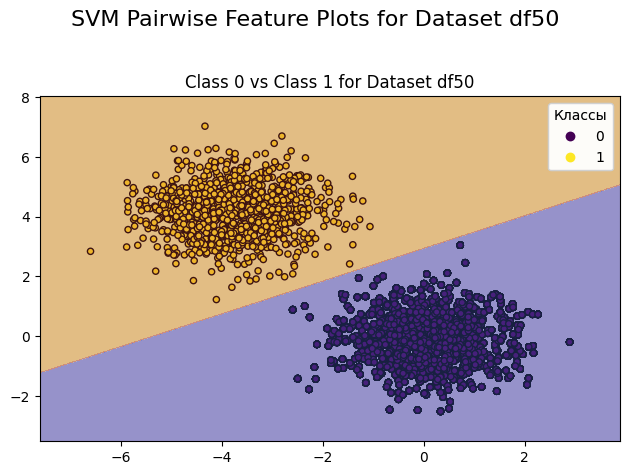

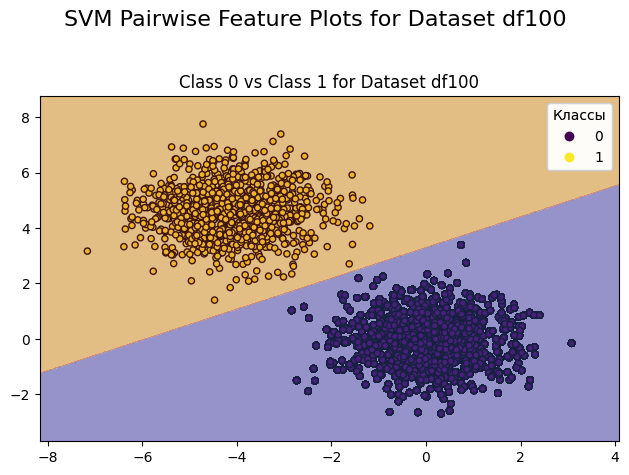

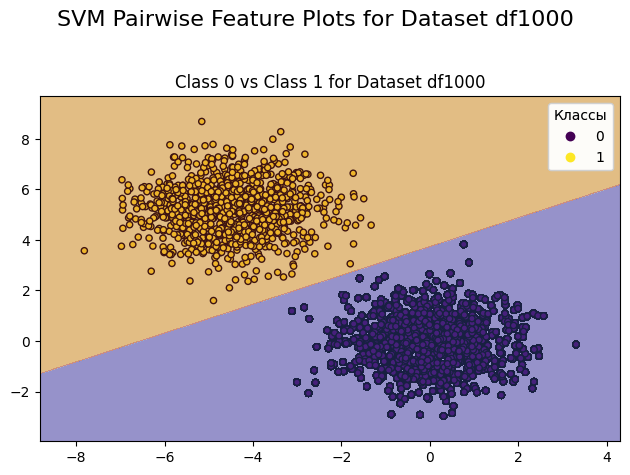

c:\Users\user\Desktop\pitux\тср\lab_1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


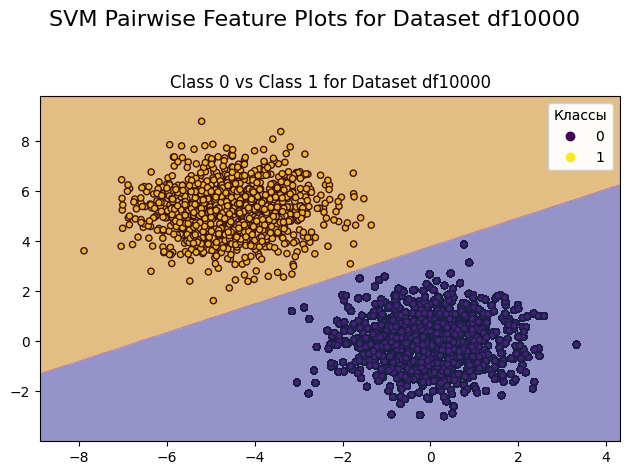

In [13]:
for dataset_name, dataset in repeated_datasets.items():
    dataset = dataset[dataset['class'].isin(selected_classes)]
    X = dataset.drop(['class'] + unselected_features, axis='columns')
    y = dataset['class']

    features_names = X.columns

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    svm = SVC(kernel='linear', class_weight='balanced' , C=1.0)
    svm.fit(X_scaled, y)

    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=20, edgecolor='k')
    legend1 = plt.legend(*scatter.legend_elements(), title="Классы")
    plt.gca().add_artist(legend1)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.title(f'Class {selected_classes[0]} vs Class {selected_classes[1]} for Dataset {dataset_name}')
    plt.suptitle(f'SVM Pairwise Feature Plots for Dataset {dataset_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

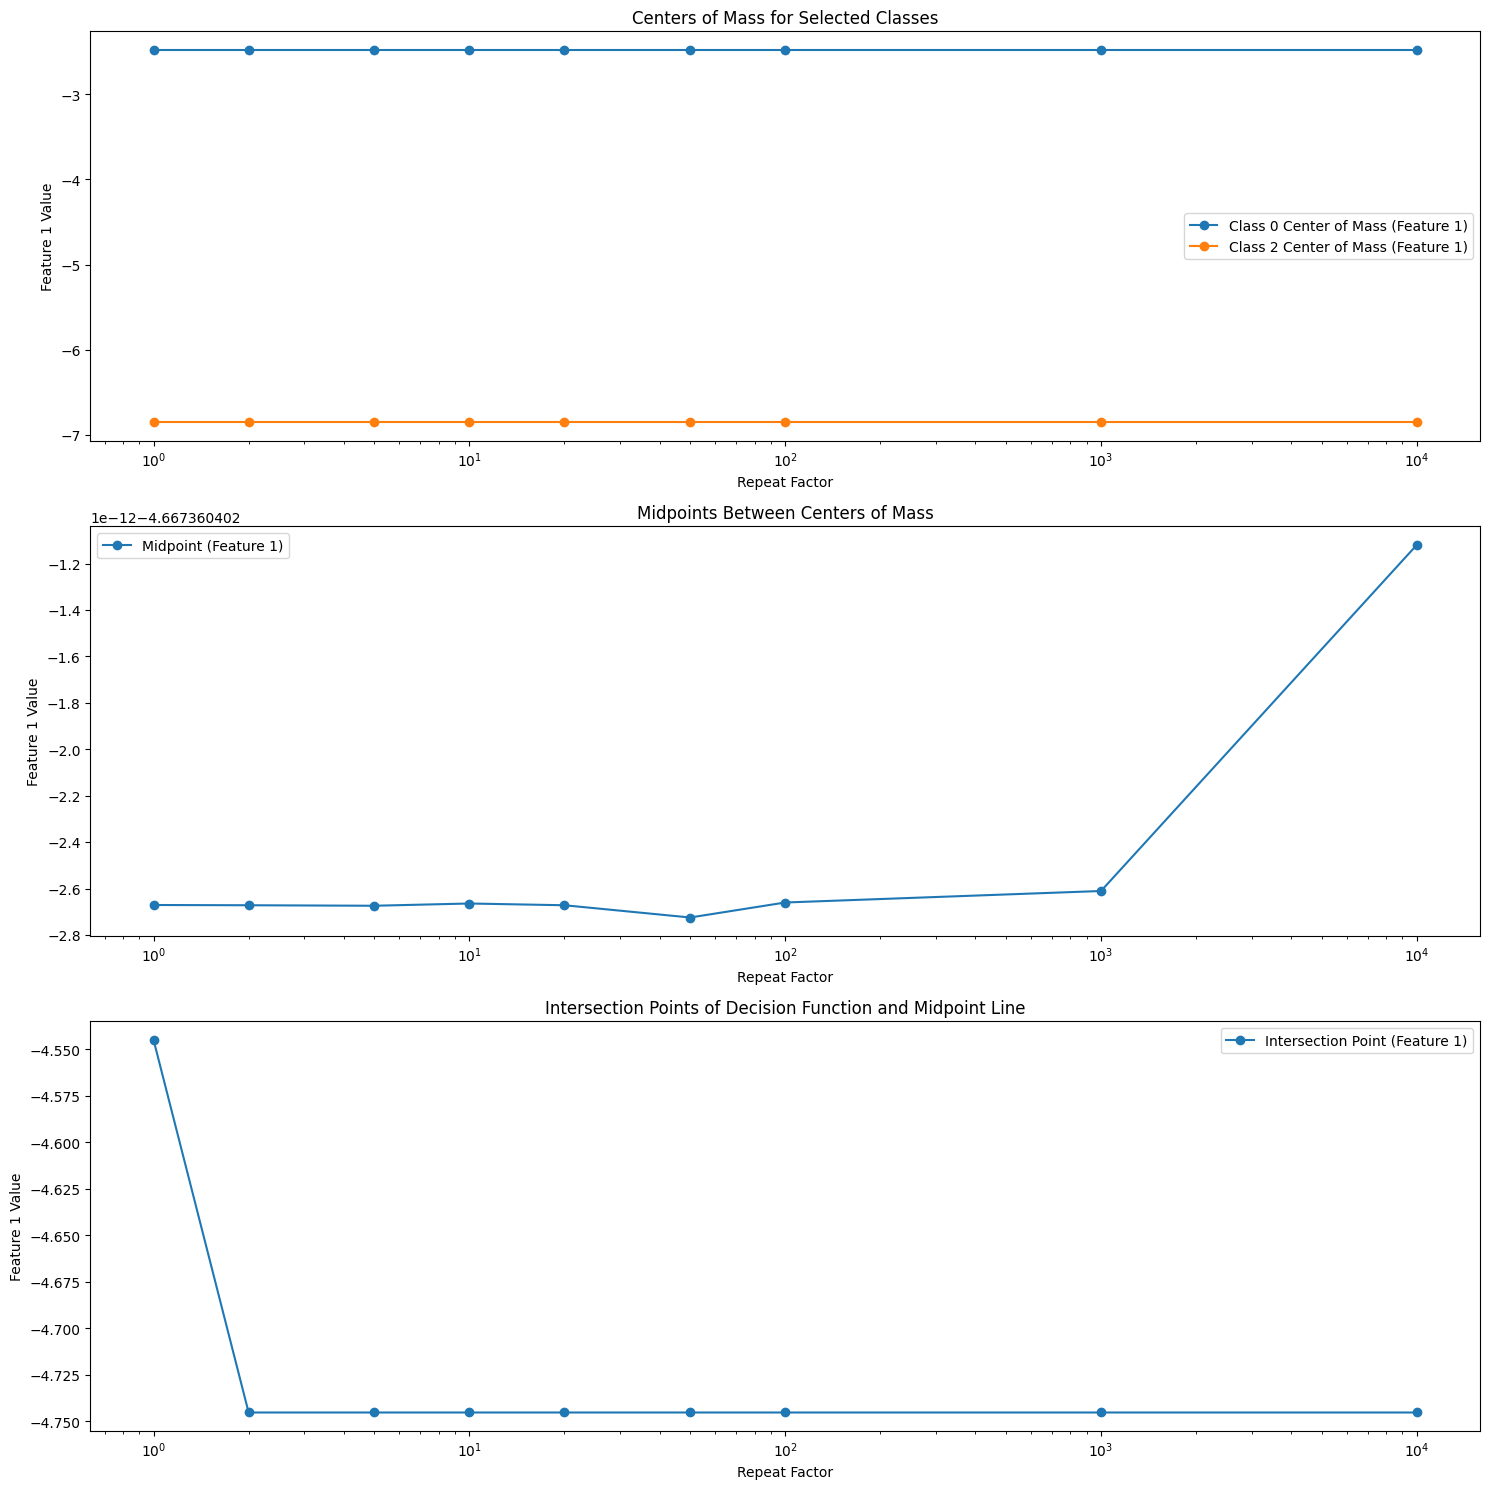

In [14]:
selected_classes = [0, 1]
unselected_features = ['feature_2', 'feature_3']
repeat_factors = [1, 2, 5, 10, 20, 50, 100, 1000, 10000]

centers_of_mass = []
midpoints = []
intersection_points = []

for dataset_name, dataset in repeated_datasets.items():
    dataset = dataset[dataset['class'].isin(selected_classes)]
    
    X = dataset.drop(['class'] + unselected_features, axis='columns')
    y = dataset['class']

    class_centers = []
    for cls in selected_classes:
        class_data = X[y == cls]
        class_center = class_data.mean(axis=0)
        class_centers.append(class_center)

    midpoint = (class_centers[0] + class_centers[1]) / 2

    svm_model = SVC(kernel='linear')
    svm_model.fit(X.values, y)

    w = svm_model.coef_[0]
    a = -w[0] / w[1] 
    b = - (svm_model.intercept_[0]) / w[1]  
    x_intersection = (midpoint.iloc[1] - b) / a
    intersection_point = np.array([x_intersection, midpoint.iloc[1]])


    centers_of_mass.append(class_centers)
    midpoints.append(midpoint)
    intersection_points.append(intersection_point)

centers_of_mass = np.array(centers_of_mass)
midpoints = np.array(midpoints)
intersection_points = np.array(intersection_points)

centers_class_0 = centers_of_mass[:, 0, 0]
centers_class_2 = centers_of_mass[:, 1, 0]
midpoint_feature_1 = midpoints[:, 0]  
intersection_point_feature_1 = intersection_points[:, 0]  

plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(repeat_factors, centers_class_0, label='Class 0 Center of Mass (Feature 1)', marker='o')
plt.plot(repeat_factors, centers_class_2, label='Class 2 Center of Mass (Feature 1)', marker='o')
plt.xlabel('Repeat Factor')
plt.ylabel('Feature 1 Value')
plt.title('Centers of Mass for Selected Classes')
plt.xscale('log')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(repeat_factors, midpoint_feature_1, label='Midpoint (Feature 1)', marker='o')
plt.xlabel('Repeat Factor')
plt.ylabel('Feature 1 Value')
plt.title('Midpoints Between Centers of Mass')
plt.xscale('log')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(repeat_factors, intersection_point_feature_1, label='Intersection Point (Feature 1)', marker='o')
plt.xlabel('Repeat Factor')
plt.ylabel('Feature 1 Value')
plt.title('Intersection Points of Decision Function and Midpoint Line')
plt.xscale('log')
plt.legend()

plt.tight_layout()
plt.show()

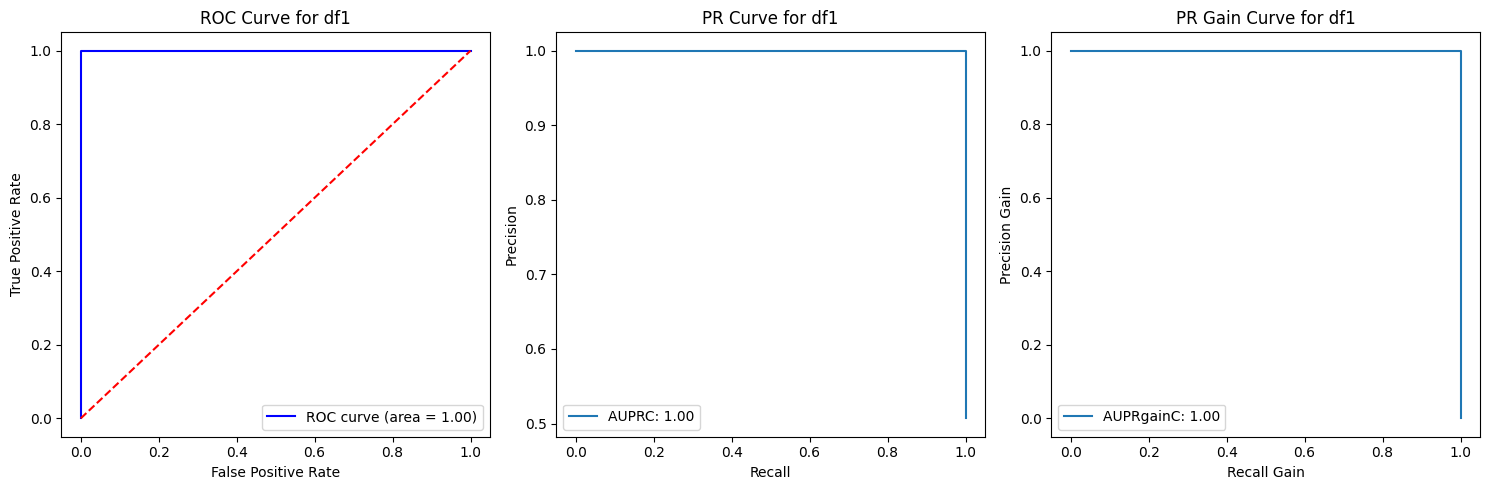

Sensitivity: 1.00, Specificity: 1.00


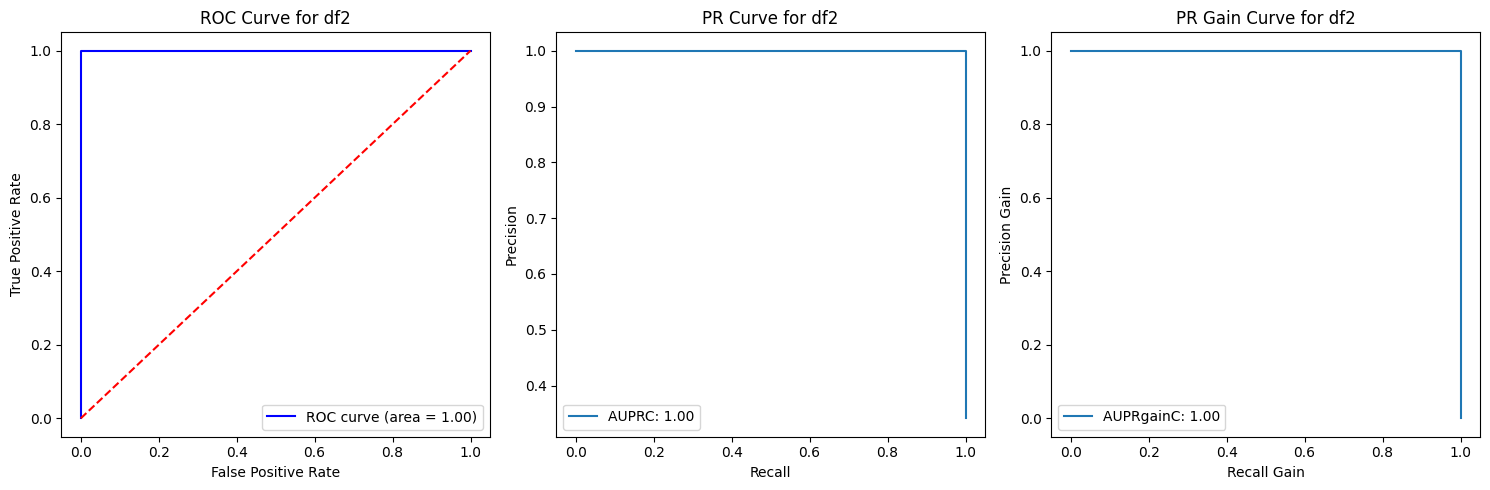

Sensitivity: 1.00, Specificity: 1.00


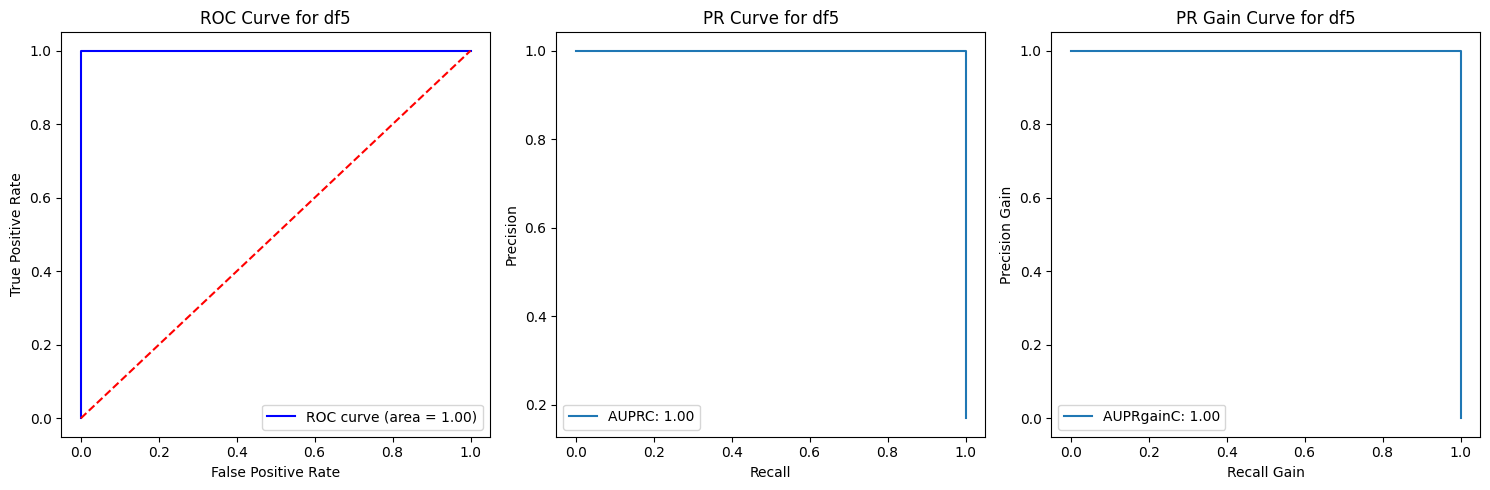

Sensitivity: 1.00, Specificity: 1.00


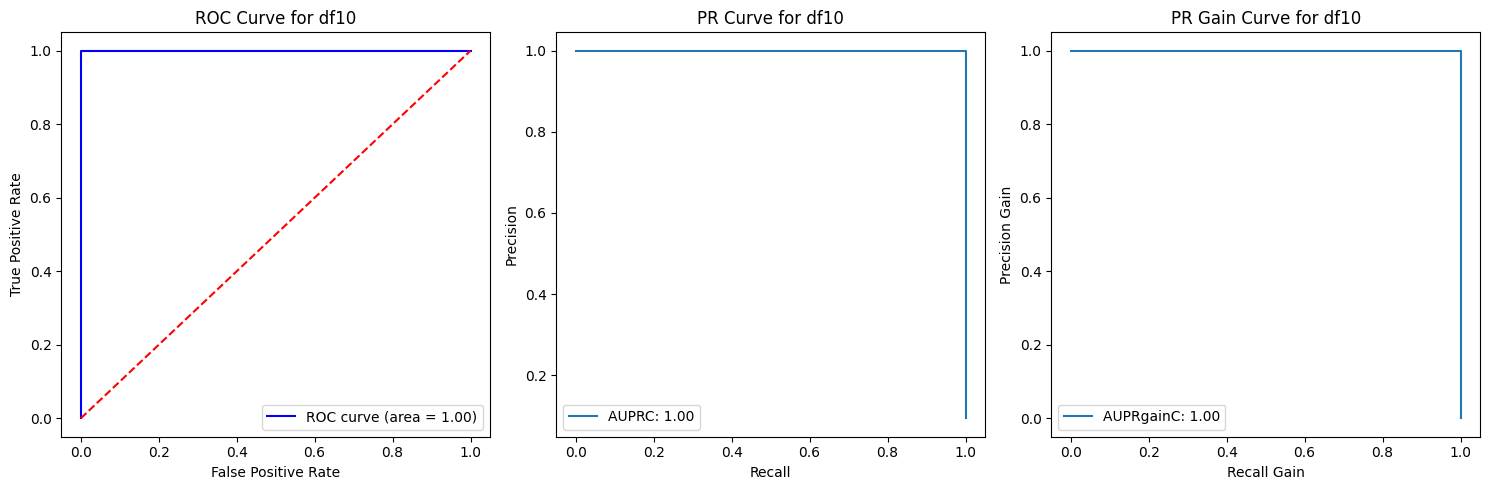

Sensitivity: 1.00, Specificity: 1.00


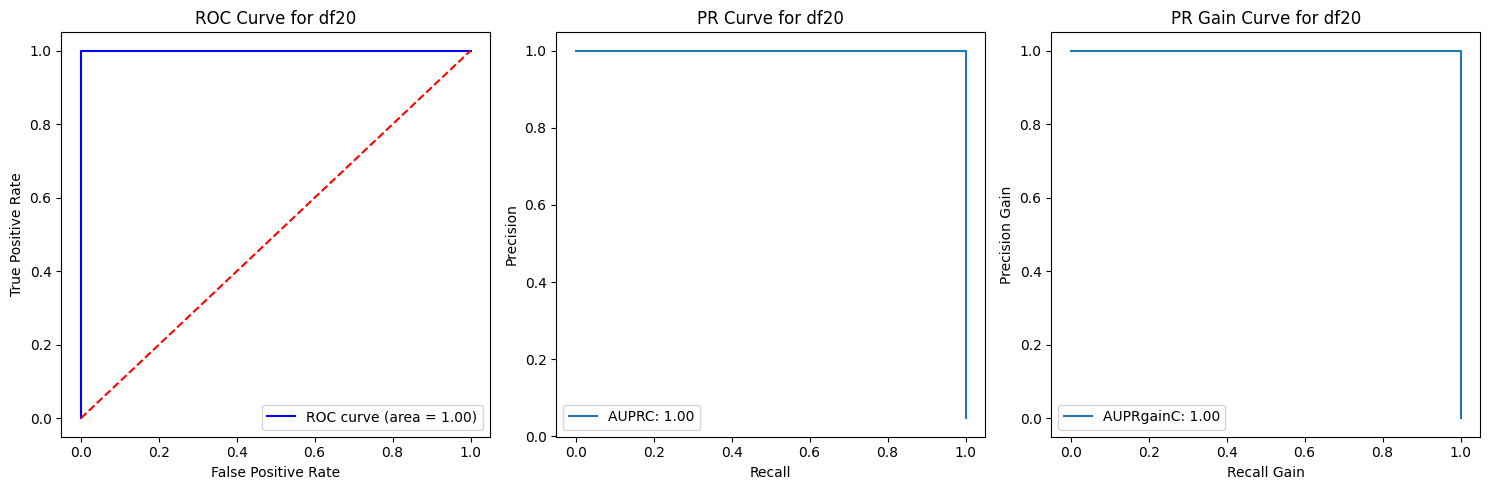

Sensitivity: 1.00, Specificity: 1.00


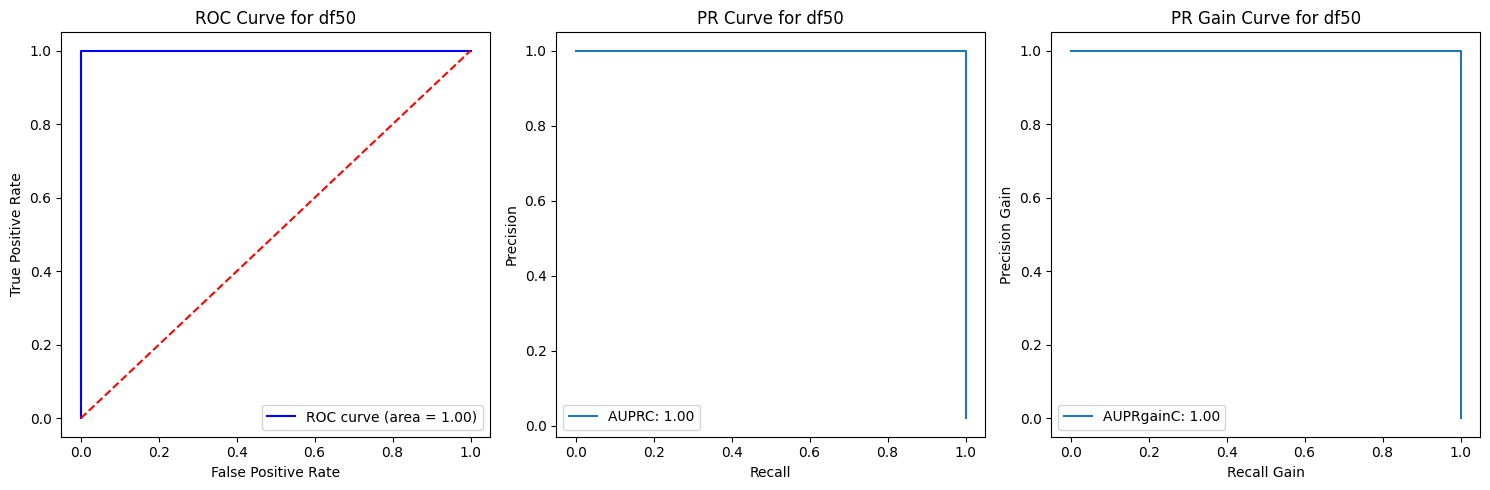

Sensitivity: 1.00, Specificity: 1.00


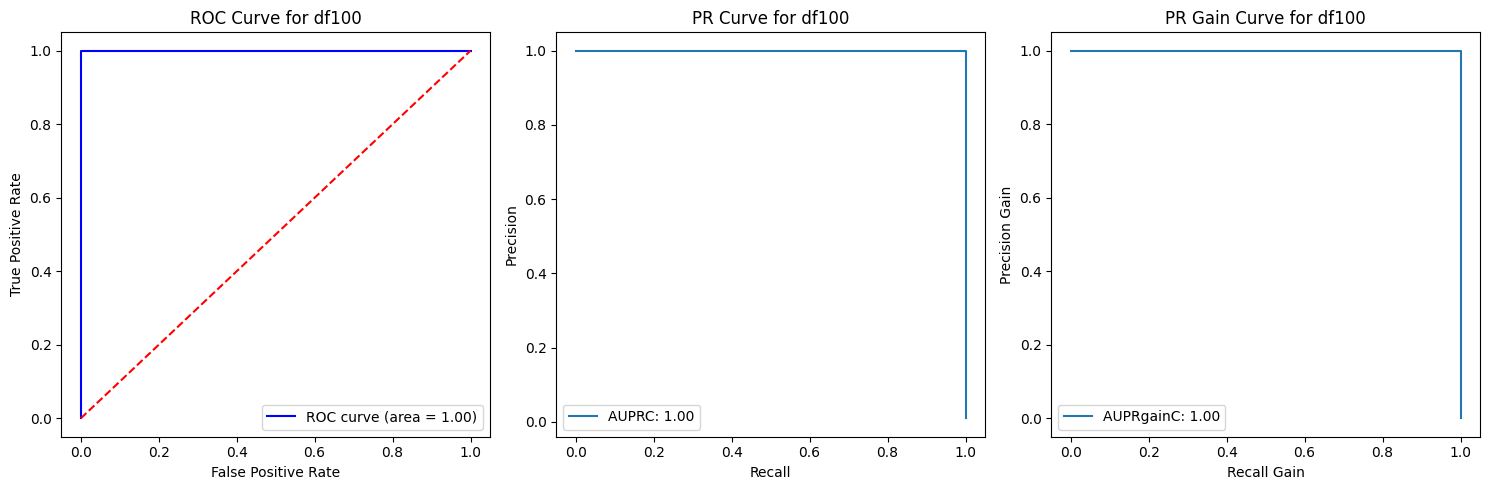

Sensitivity: 1.00, Specificity: 1.00


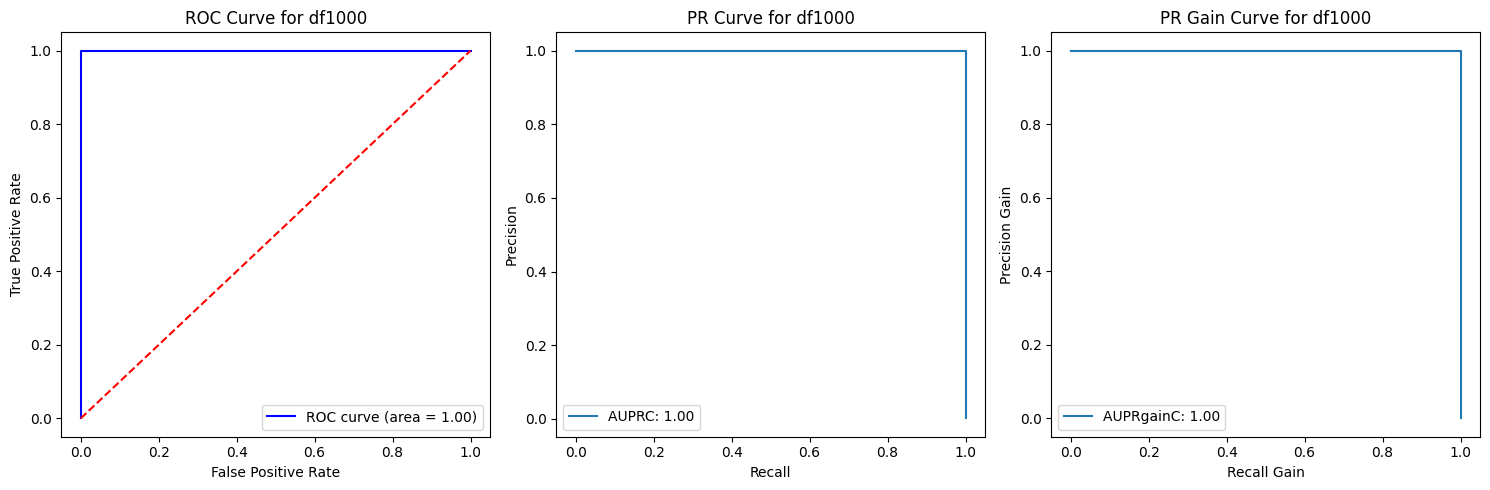

Sensitivity: 1.00, Specificity: 1.00


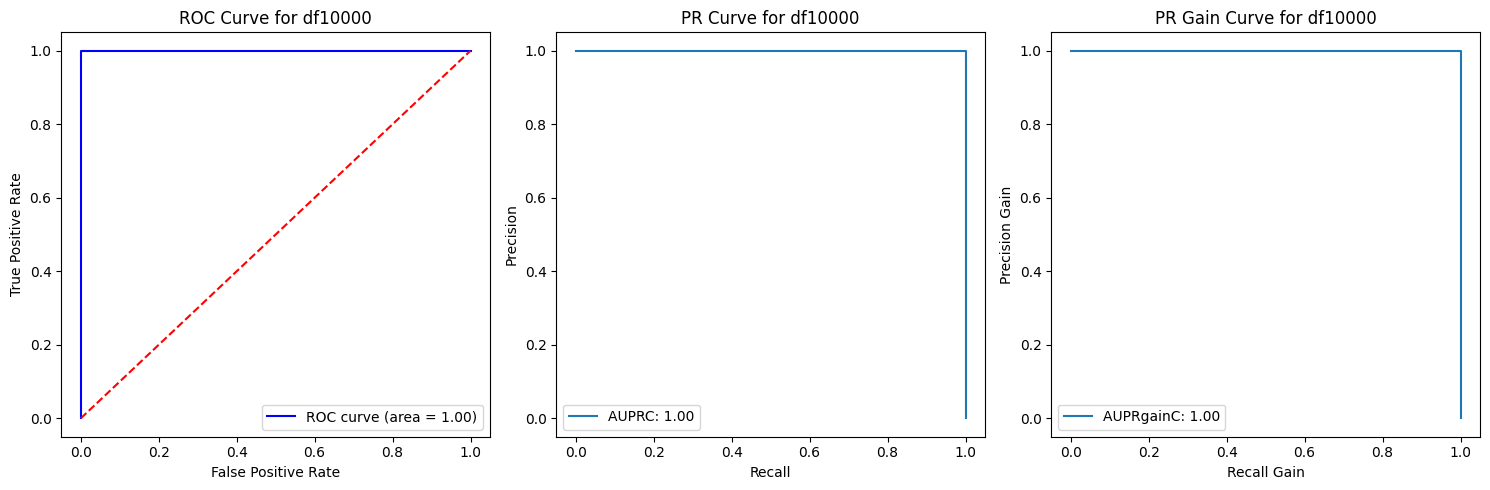

Sensitivity: 1.00, Specificity: 1.00


In [15]:
def evaluate_lda_model(dataset,dataset_name):
    selected_classes = dataset[dataset['class'].isin([0, 2])]
    X = selected_classes[['feature_3', 'feature_4']] 
    y = selected_classes['class']
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.5, random_state=42)

    lda = LDA()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
    else:
        sensitivity = specificity = None

    if hasattr(lda, "predict_proba"): 
        y_prob = lda.predict_proba(X_test)[:, 1]
    else:
        y_prob = lda.decision_function(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
    auprc = auc(recall, precision)

    P = sum(y_test)
    N = len(y_test) - P
    pi = P / (P + N)

    precision_gain = (precision - pi) / (1 - pi)
    recall_gain = recall
    auprgainc = auc(recall_gain, precision_gain)

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc='lower right')

    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve for {dataset_name}')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(recall_gain, precision_gain, label=f'AUPRgainC: {auprgainc:.2f}')
    plt.xlabel('Recall Gain')
    plt.ylabel('Precision Gain')
    plt.title(f'PR Gain Curve for {dataset_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    if sensitivity is not None and specificity is not None:
        print(f"Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")
    else:
        print("Sensitivity and specificity could not be calculated due to unexpected confusion matrix shape.")

for name, dataset in repeated_datasets.items():
    evaluate_lda_model(dataset, name)


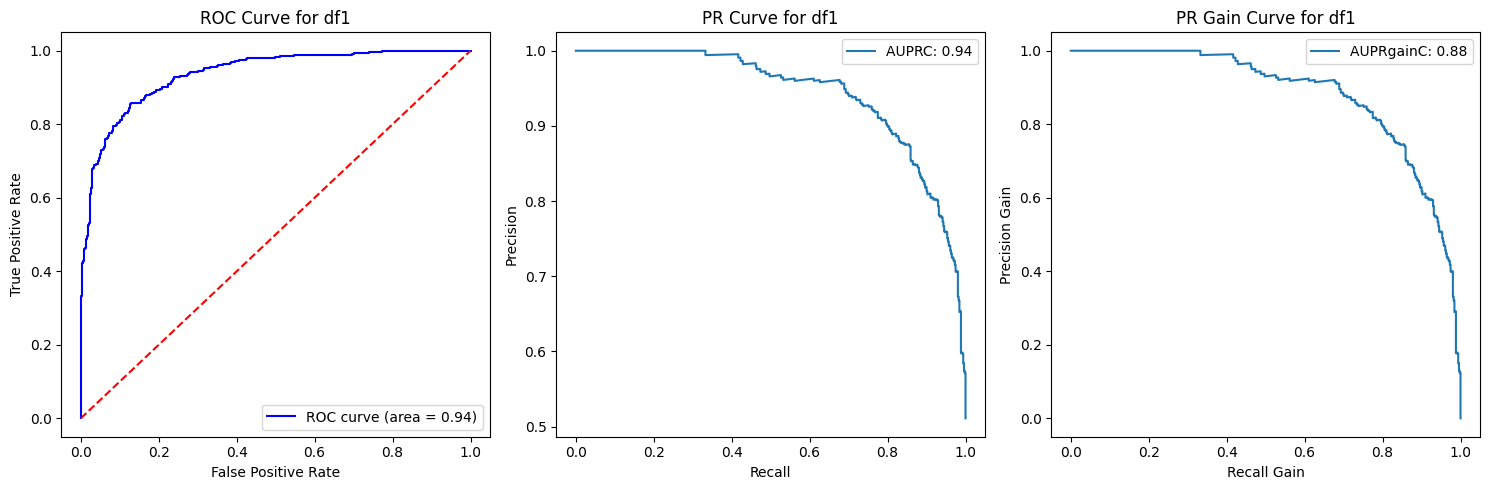

Sensitivity: 0.85, Specificity: 0.88


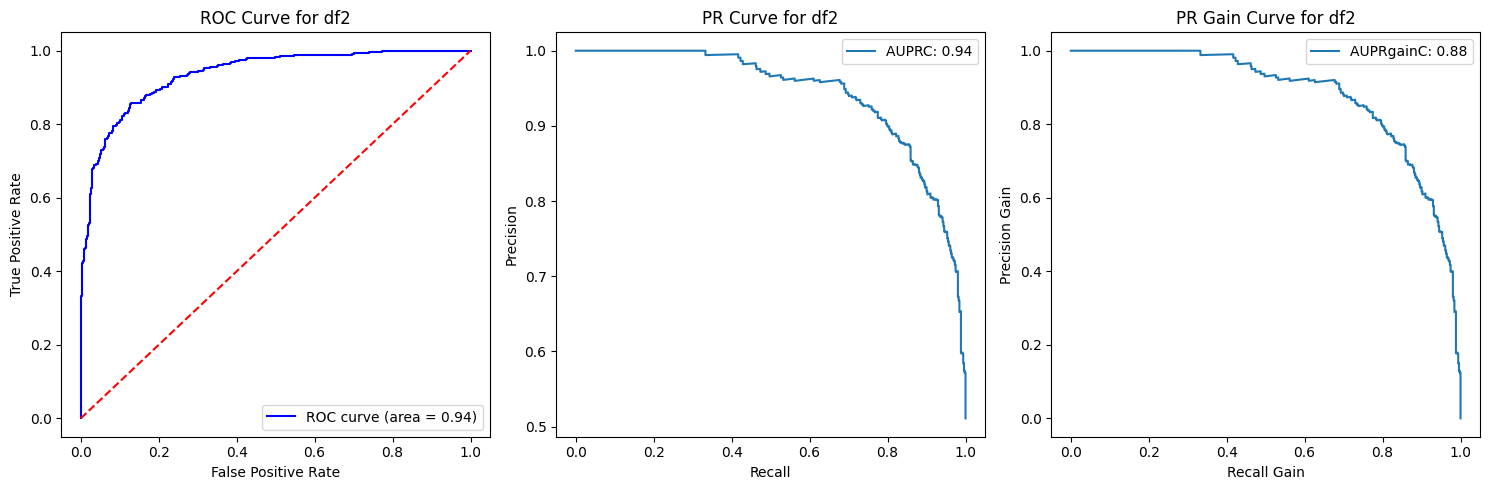

Sensitivity: 0.85, Specificity: 0.88


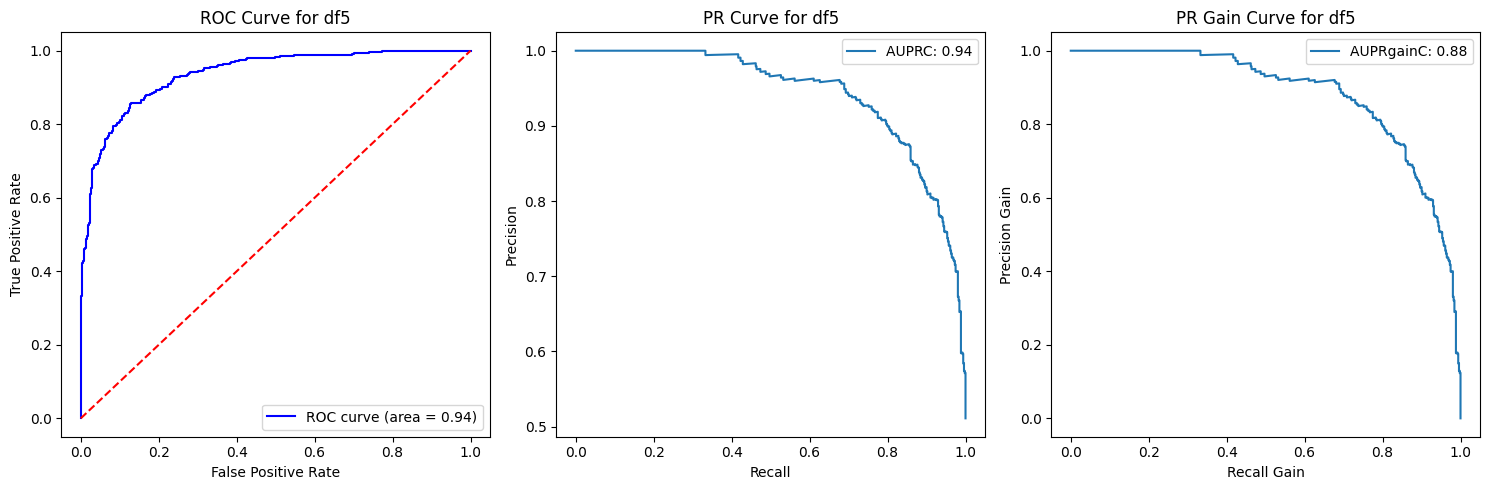

Sensitivity: 0.85, Specificity: 0.88


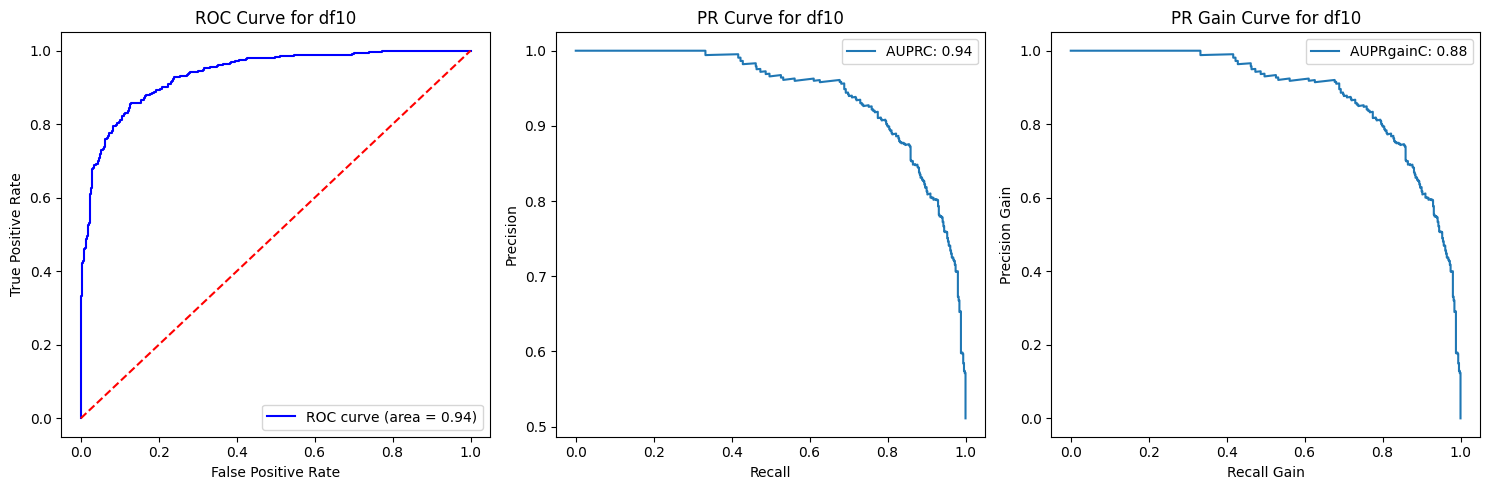

Sensitivity: 0.85, Specificity: 0.88


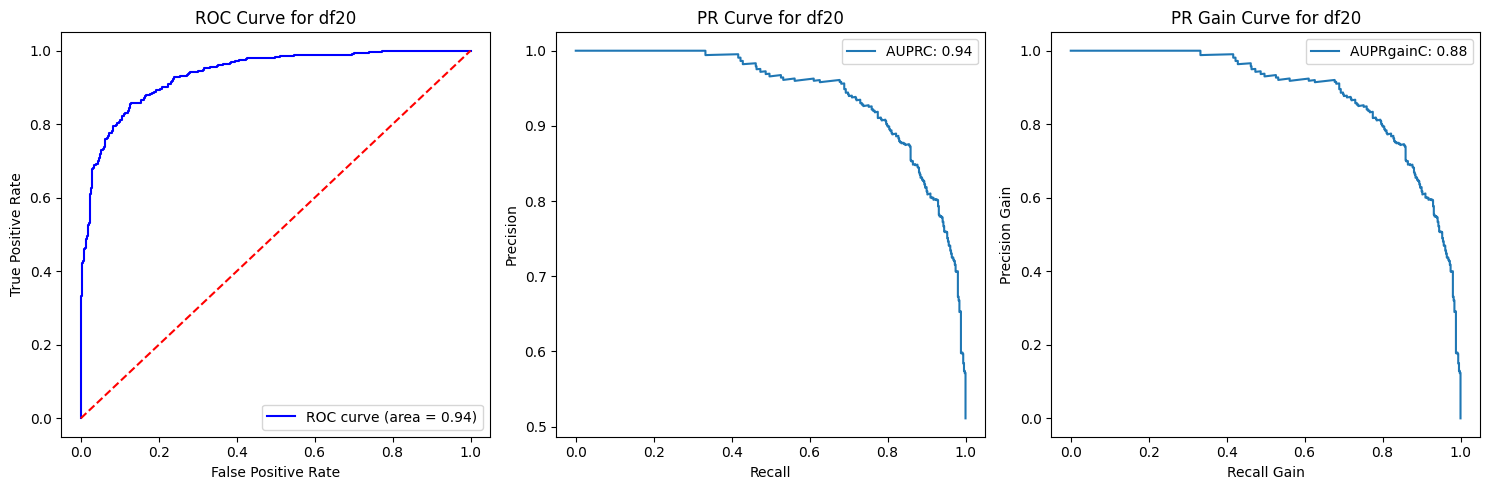

Sensitivity: 0.85, Specificity: 0.88


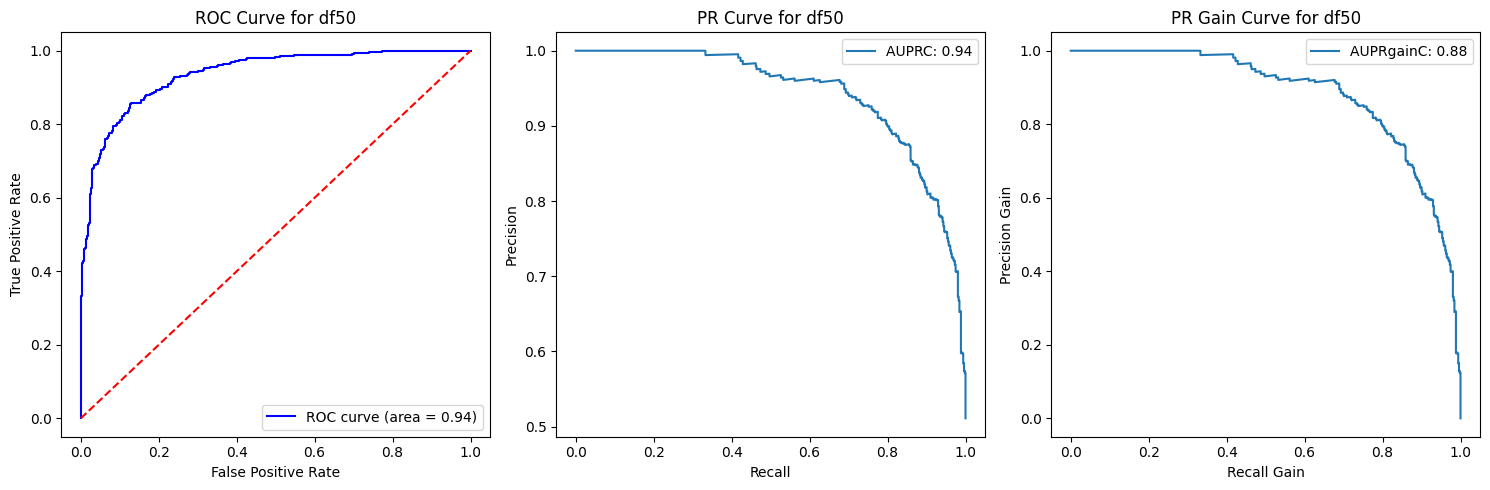

Sensitivity: 0.85, Specificity: 0.88


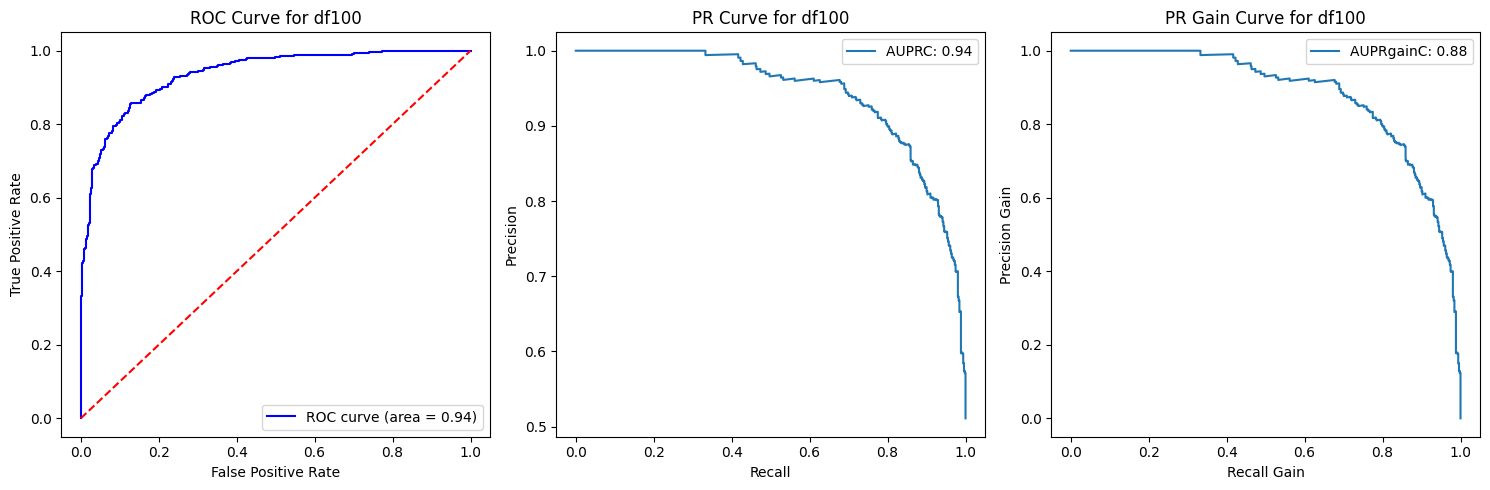

Sensitivity: 0.85, Specificity: 0.88


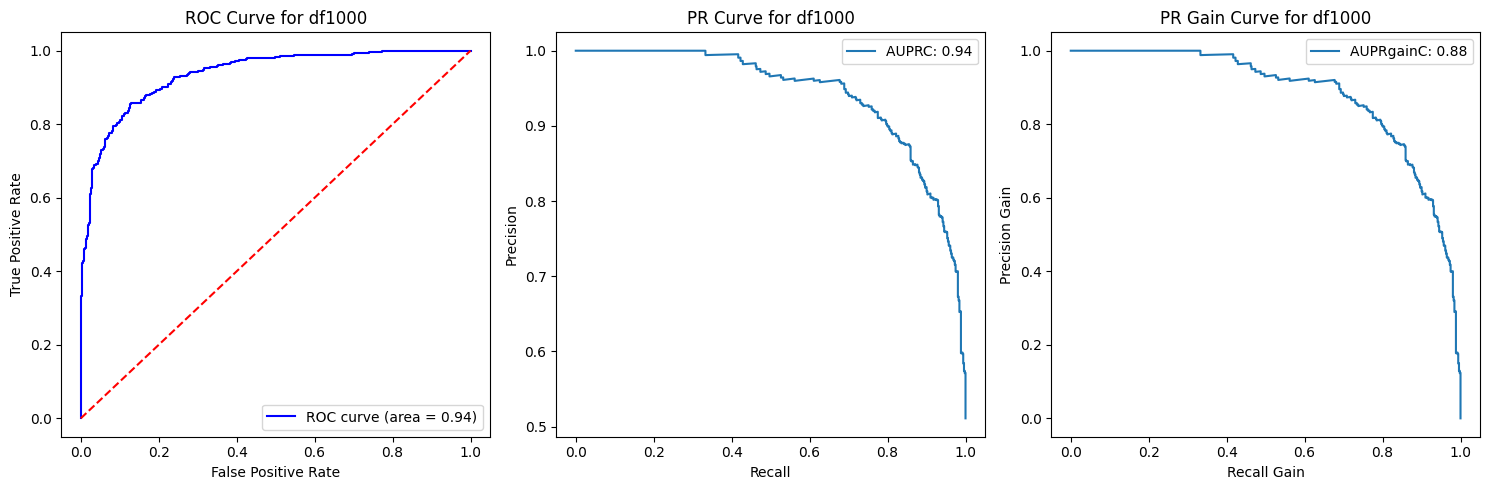

Sensitivity: 0.85, Specificity: 0.88


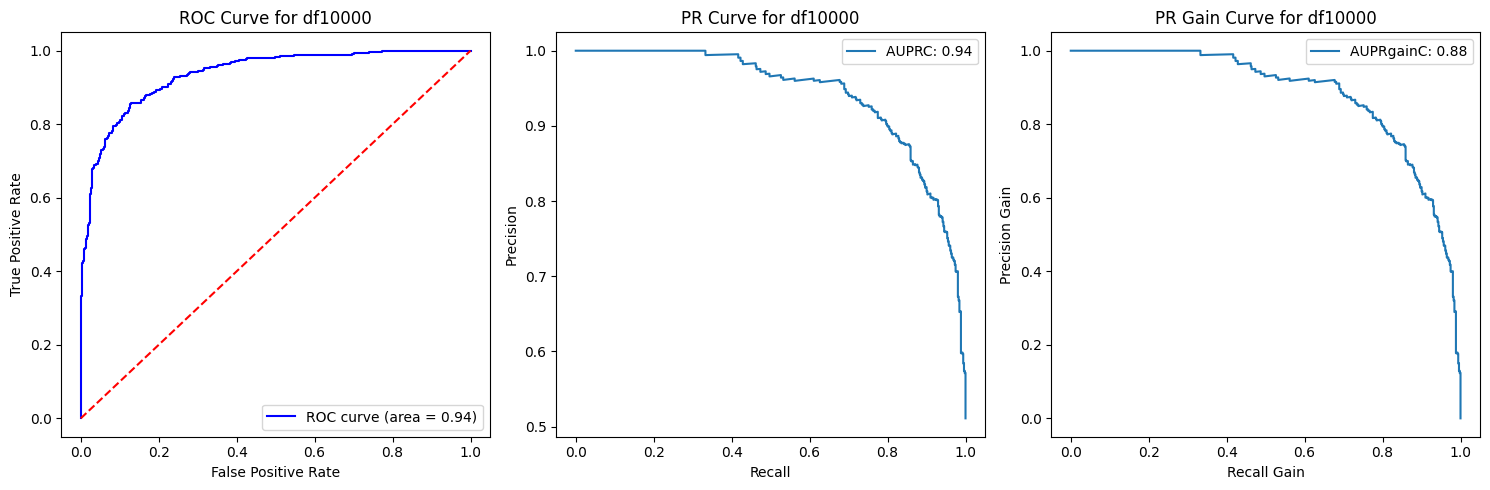

Sensitivity: 0.85, Specificity: 0.88


In [16]:
def evaluate_lda_model(dataset,dataset_name):
    selected_classes = dataset[dataset['class'].isin([1, 2])]
    X = selected_classes[['feature_3', 'feature_4']] 
    y = selected_classes['class']
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.5, random_state=42)

    lda = LDA()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
    else:
        sensitivity = specificity = None

    if hasattr(lda, "predict_proba"): 
        y_prob = lda.predict_proba(X_test)[:, 1]
    else:
        y_prob = lda.decision_function(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
    auprc = auc(recall, precision)

    P = sum(y_test)
    N = len(y_test) - P
    pi = P / (P + N)

    precision_gain = (precision - pi) / (1 - pi)
    recall_gain = recall
    auprgainc = auc(recall_gain, precision_gain)

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc='lower right')

    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve for {dataset_name}')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(recall_gain, precision_gain, label=f'AUPRgainC: {auprgainc:.2f}')
    plt.xlabel('Recall Gain')
    plt.ylabel('Precision Gain')
    plt.title(f'PR Gain Curve for {dataset_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    if sensitivity is not None and specificity is not None:
        print(f"Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")
    else:
        print("Sensitivity and specificity could not be calculated due to unexpected confusion matrix shape.")

for name, dataset in repeated_datasets.items():
    evaluate_lda_model(dataset, name)


In [17]:
def bootstrap_pr_auc(y_real, y_proba, n_bootstraps=1000, ci=80):
    auprcs = []
    for _ in range(n_bootstraps):
        y_real_sample, y_proba_sample = resample(y_real, y_proba)
        precision, recall, _ = precision_recall_curve(y_real_sample, y_proba_sample)
        auprcs.append(auc(recall, precision))
    lower_bound = np.percentile(auprcs, (100 - ci) / 2)
    upper_bound = np.percentile(auprcs, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound

In [18]:
def bootstrap_roc_auc(y_real, y_proba, n_bootstraps=1000, ci=80):
    aucs = []
    for _ in range(n_bootstraps):
        y_real_sample, y_proba_sample = resample(y_real, y_proba)
        fpr, tpr, _ = roc_curve(y_real_sample, y_proba_sample)
        aucs.append(auc(fpr, tpr))
    lower_bound = np.percentile(aucs, (100 - ci) / 2)
    upper_bound = np.percentile(aucs, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound

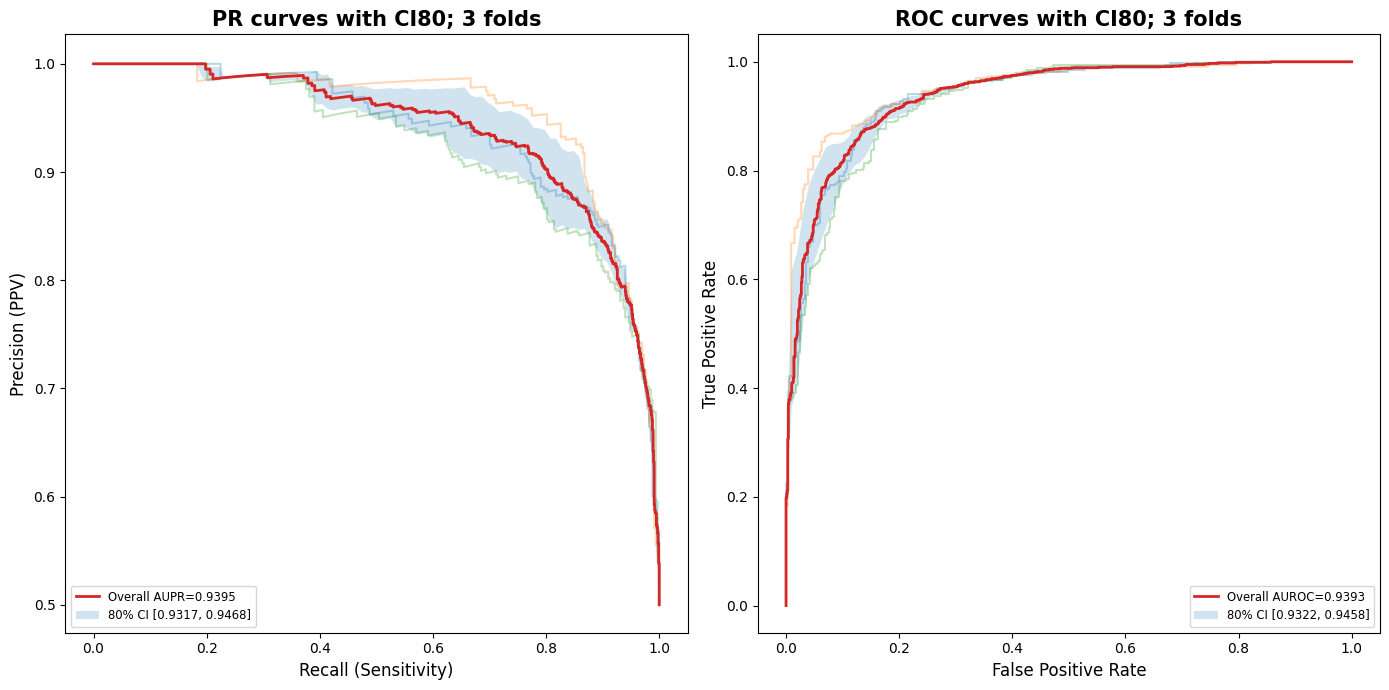

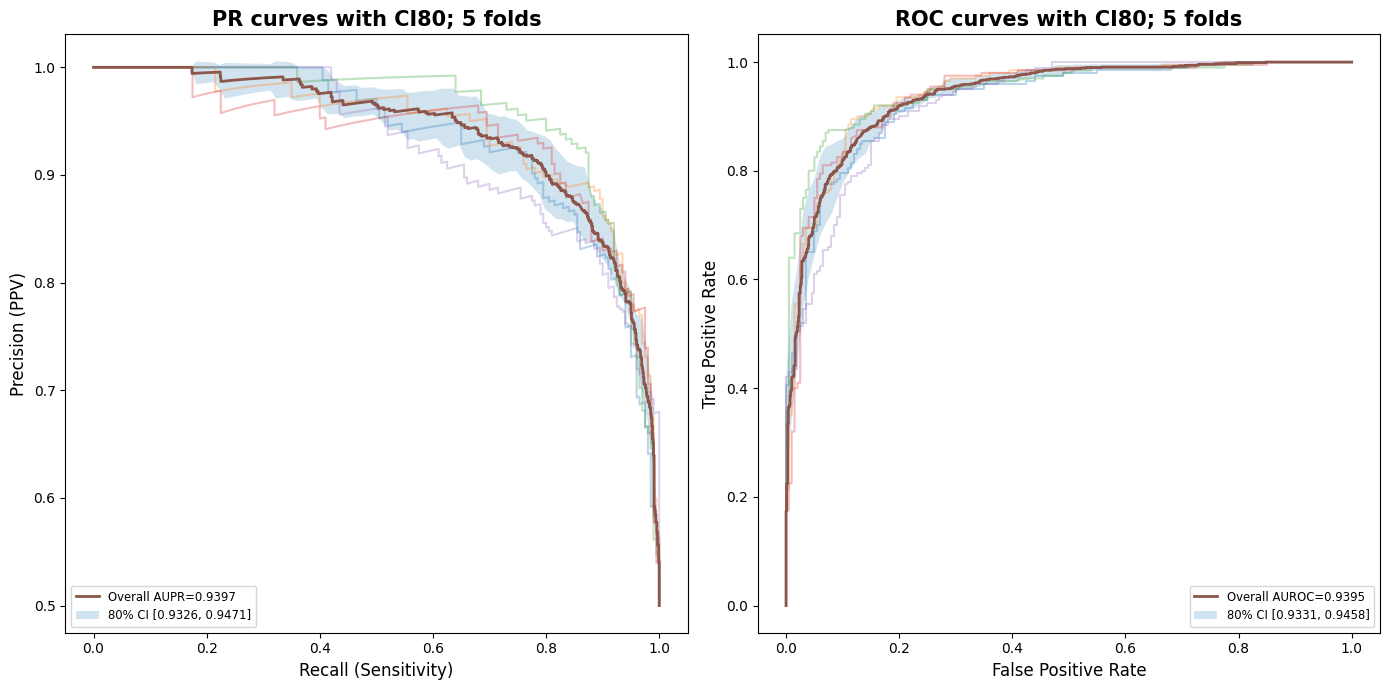

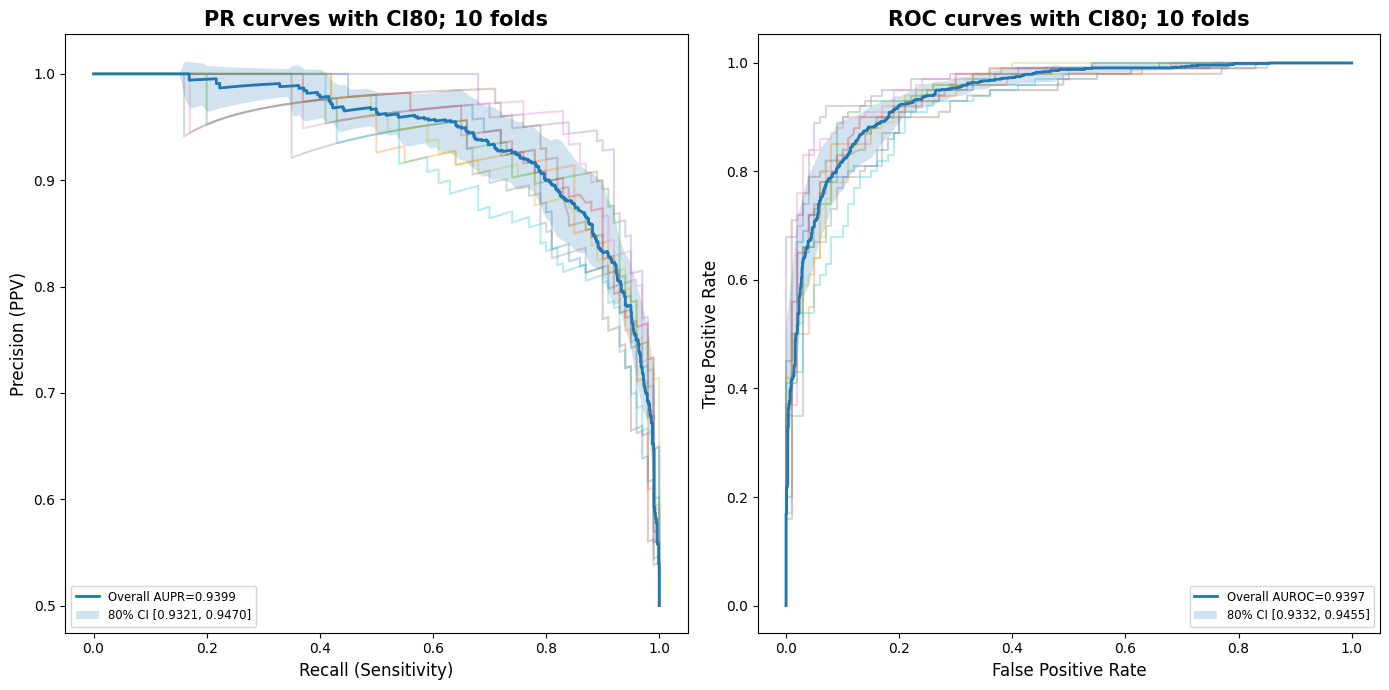

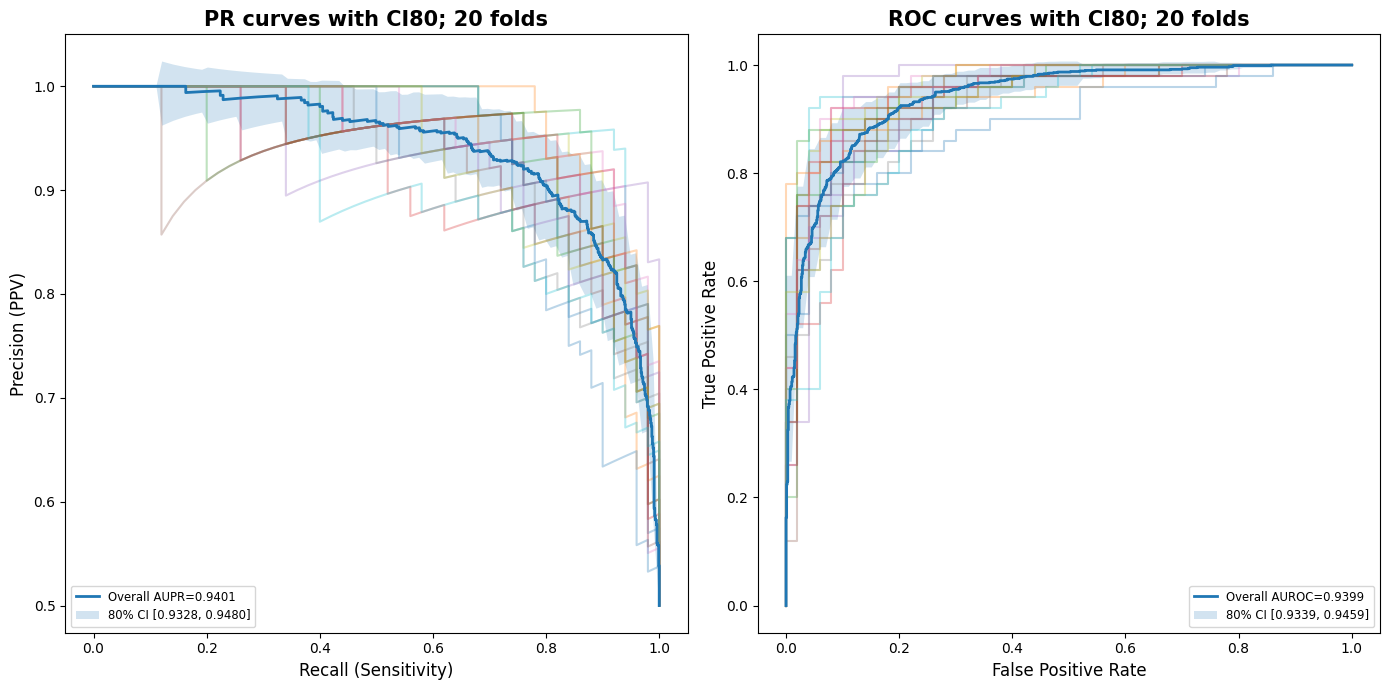

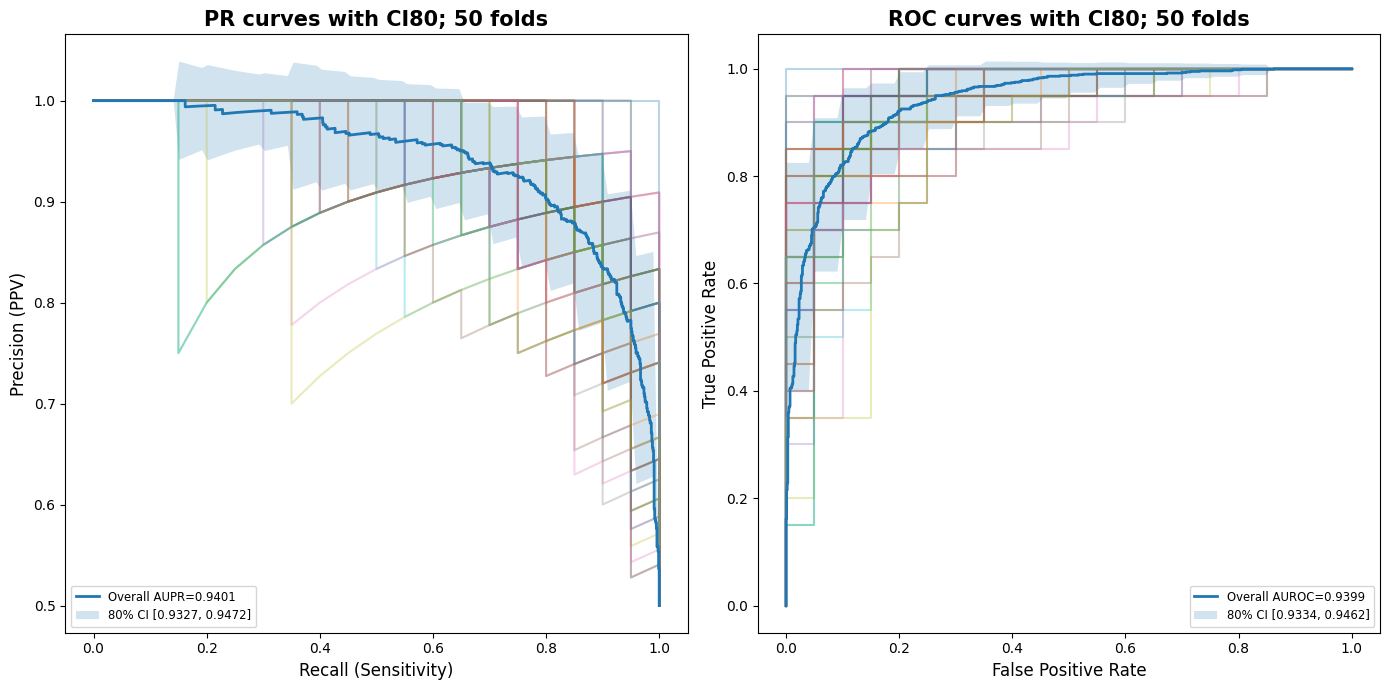

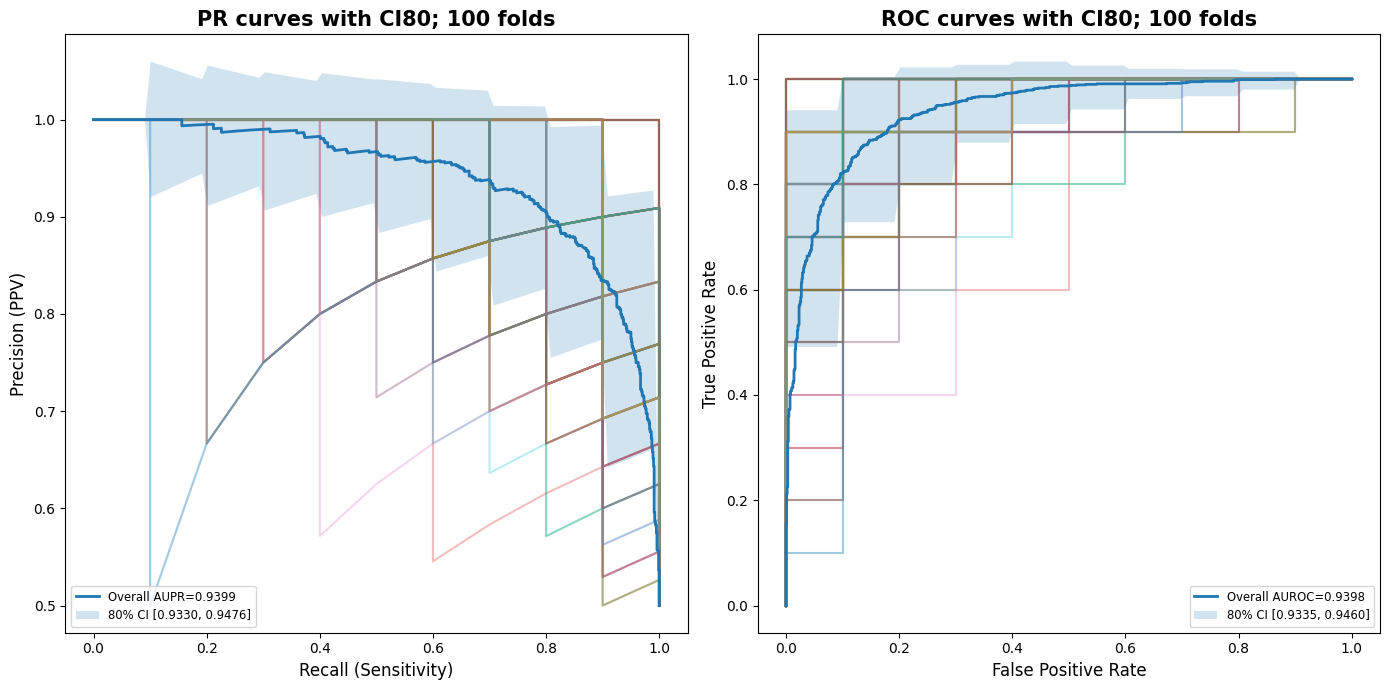

In [ ]:
k_list = [3, 5, 10, 20, 50, 100]

for k in k_list:
    y_real = []
    y_proba = []
    precision_array = []
    roc_tpr_array = []
    recall_array = np.linspace(0, 1, 100)
    roc_fpr_array = np.linspace(0, 1, 100)
    
    df_selected = repeated_datasets['df100'][repeated_datasets['df100']['class'].isin([1, 2])][['feature_3', 'feature_4', 'class']]
    X = df_selected[['feature_3', 'feature_4']]
    
    y_encoded = df_selected['class'].apply(lambda x: 0 if x == 1 else 1)
    
    skf = StratifiedKFold(n_splits=k)

    _, axes = plt.subplots(1, 2, figsize=(14, 7))
    predictor = SVC(probability=True, random_state=42)

    for i, (train_index, test_index) in enumerate(skf.split(X, y_encoded)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_encoded.iloc[train_index], y_encoded.iloc[test_index]
        
        predictor.fit(X_train, y_train)
        pred_proba = predictor.predict_proba(X_test)
        
        # Precision-recall curve
        precision_fold, recall_fold, _ = precision_recall_curve(y_test, pred_proba[:, 1])
        precision_fold, recall_fold = precision_fold[::-1], recall_fold[::-1]
        
        prec_array = np.interp(recall_array, recall_fold, precision_fold)
        pr_auc = auc(recall_array, prec_array)
        precision_array.append(prec_array)
    
        lab_fold_pr = f'Fold {i+1} AUPR={pr_auc:.4f}'
        axes[0].plot(recall_fold, precision_fold, alpha=0.3)
    
        # ROC curve
        fpr_fold, tpr_fold, _ = roc_curve(y_test, pred_proba[:, 1])
        roc_auc = auc(fpr_fold, tpr_fold)
        roc_tpr_interp = np.interp(roc_fpr_array, fpr_fold, tpr_fold)
        roc_tpr_array.append(roc_tpr_interp)
    
        lab_fold_roc = f'Fold {i+1} AUROC={roc_auc:.4f}'
        axes[1].plot(fpr_fold, tpr_fold, alpha=0.3) 
    
        y_real.append(y_test)
        y_proba.append(pred_proba[:, 1])
    
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    # Overall Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    lab_pr = f'Overall AUPR={auc(recall, precision):.4f}'
    axes[0].plot(recall, precision, lw=2, label=lab_pr)
    
    # Overall ROC curve
    fpr, tpr, _ = roc_curve(y_real, y_proba)
    lab_roc = f'Overall AUROC={auc(fpr, tpr):.4f}'
    axes[1].plot(fpr, tpr, lw=2, label=lab_roc)
    
    # Confidence intervals for PR and ROC
    lower_ci_pr, upper_ci_pr = bootstrap_pr_auc(y_real, y_proba, n_bootstraps=1000, ci=80)
    mean_precision = np.mean(precision_array, axis=0)
    std_precision = np.std(precision_array, axis=0)
    ci_lower_pr, ci_upper_pr = mean_precision - std_precision, mean_precision + std_precision
    axes[0].fill_between(recall_array, ci_lower_pr, ci_upper_pr, alpha=0.2, label=f'80% CI [{lower_ci_pr:.4f}, {upper_ci_pr:.4f}]')
    
    lower_ci_roc, upper_ci_roc = bootstrap_roc_auc(y_real, y_proba, n_bootstraps=1000, ci=80)
    mean_tpr = np.mean(roc_tpr_array, axis=0)
    std_tpr = np.std(roc_tpr_array, axis=0)
    ci_lower_roc, ci_upper_roc = mean_tpr - std_tpr, mean_tpr + std_tpr
    axes[1].fill_between(roc_fpr_array, ci_lower_roc, ci_upper_roc, alpha=0.2, label=f'80% CI [{lower_ci_roc:.4f}, {upper_ci_roc:.4f}]')
    
    axes[0].legend(loc='lower left', fontsize='small')
    axes[0].set_title(f"PR curves with CI80; {k} folds", weight="bold", fontsize=15)
    axes[0].set_xlabel("Recall (Sensitivity)", fontsize=12)
    axes[0].set_ylabel("Precision (PPV)", fontsize=12)
    
    axes[1].legend(loc='lower right', fontsize='small')
    axes[1].set_title(f"ROC curves with CI80; {k} folds", weight="bold", fontsize=15)
    axes[1].set_xlabel("False Positive Rate", fontsize=12)
    axes[1].set_ylabel("True Positive Rate", fontsize=12)
    
    plt.tight_layout()
    plt.show()
